In [51]:
from idlelib.tree import wheel_event
from platform import win32_ver



import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Greeks visualization

In [40]:
def black_scholes(S, K, T, r, sigma, option_type='Call'):
    """
    Calculates Price and Greeks for a single option.
    S: Spot Price
    K: Strike Price
    T: Time to Maturity (years)
    r: Risk-free Interest Rate (decimal)
    sigma: Volatility (decimal)
    option_type: 'Call' or 'Put'
    """
    # Safety against division by zero for T
    if T <= 1e-5:
        T = 1e-5

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    N_neg_d1 = norm.cdf(-d1)
    N_neg_d2 = norm.cdf(-d2)
    pdf_d1 = norm.pdf(d1)

    if option_type == 'Call':
        price = S * N_d1 - K * np.exp(-r * T) * N_d2
        delta = N_d1
        theta = (- (S * pdf_d1 * sigma) / (2 * np.sqrt(T))
                 - r * K * np.exp(-r * T) * N_d2)
        rho = K * T * np.exp(-r * T) * N_d2

        # Payoff at expiration (Intrinsic Value)
        payoff = np.maximum(S - K, 0)

    else: # Put
        price = K * np.exp(-r * T) * N_neg_d2 - S * N_neg_d1
        delta = N_d1 - 1
        theta = (- (S * pdf_d1 * sigma) / (2 * np.sqrt(T))
                 + r * K * np.exp(-r * T) * N_neg_d2)
        rho = -K * T * np.exp(-r * T) * N_neg_d2

        # Payoff at expiration
        payoff = np.maximum(K - S, 0)

    # Gamma and Vega are the same for Calls and Puts
    gamma = pdf_d1 / (S * sigma * np.sqrt(T))
    vega = S * pdf_d1 * np.sqrt(T)

    # Return dictionary of metrics
    return {
        'Price': price,
        'Payoff': payoff,
        'Delta': delta,
        'Gamma': gamma,
        'Theta': theta,
        'Vega': vega / 100, # Usually shown per 1% change
        'Rho': rho / 100    # Usually shown per 1% change
    }

In [44]:
S=100
T=0.5
sigma=0.3
K=110
r=0.035
call=black_scholes(S, K, T, r, sigma)
print(call["Price"])

5.325019883911672


In [57]:
call_values=[]
strikes=np.array(range(70,150))
for i in strikes:
    K=i
    #print(i)
    call=black_scholes(S, K, T, r, sigma)
    call_values.append(call["Price"])


In [60]:
intrinsic_values=S-strikes
intrinsic_values=[max(x, 0) for x in intrinsic_values]
print(intrinsic_values)

[np.int64(30), np.int64(29), np.int64(28), np.int64(27), np.int64(26), np.int64(25), np.int64(24), np.int64(23), np.int64(22), np.int64(21), np.int64(20), np.int64(19), np.int64(18), np.int64(17), np.int64(16), np.int64(15), np.int64(14), np.int64(13), np.int64(12), np.int64(11), np.int64(10), np.int64(9), np.int64(8), np.int64(7), np.int64(6), np.int64(5), np.int64(4), np.int64(3), np.int64(2), np.int64(1), np.int64(0), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


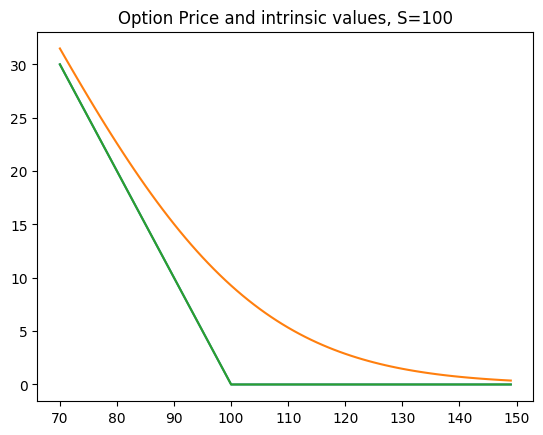

In [67]:
plt.figure()
plt.title('Option Price and intrinsic values, S=100')
plt.plot(strikes, intrinsic_values)

plt.plot(strikes, call_values)
plt.plot(strikes,intrinsic_values)

In [83]:
def calculate_portfolio_metrics(positions, spot_range, T, r, sigma):
    """
    Aggregates metrics for a portfolio of options over a range of spot prices.

    positions: List of dicts [{'type': 'Call', 'strike': 100, 'quantity': 1}, ...]
    spot_range: Numpy array of spot prices to simulate
    """
    # Initialize zero-arrays to hold the sum of all options
    aggregated = {
        'Price': np.zeros_like(spot_range),
        'Payoff': np.zeros_like(spot_range),
        'Delta': np.zeros_like(spot_range),
        'Gamma': np.zeros_like(spot_range),
        'Theta': np.zeros_like(spot_range),
        'Vega': np.zeros_like(spot_range),
        'Rho': np.zeros_like(spot_range)
    }

    for pos in positions:
        # Get metrics for this specific option
        metrics = black_scholes(
            S=spot_range,
            K=pos['strike'],
            T=T,
            r=r,
            sigma=sigma,
            option_type=pos['type']
        )

        # Add to total (multiply by quantity: +1 for Long, -1 for Short)
        qty = pos['quantity']
        for key in aggregated:
            aggregated[key] += metrics[key] * qty

    return aggregated

# Let's visualize the greeks now
## S moves now

In [84]:
def plot_greeks(spot_range, results):
    """
    Plots the Price and all Greeks from the results dictionary using Matplotlib.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Portfolio Greeks vs Spot Price', fontsize=16)

    # List of metrics to plot
    metrics = ['Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']

    # Flatten axes array for easy iteration
    axes_flat = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes_flat[i]

        # Plot the main metric curve
        ax.plot(spot_range, results[metric], label=metric, linewidth=2)

        # If plotting Price, also overlay the Payoff at Maturity
        if metric == 'Price':
            ax.plot(spot_range, results['Payoff'], label='Payoff @ Expiry',
                   linestyle='--', color='black', alpha=0.6, linewidth=1.5)
            ax.legend()

        ax.set_title(metric, fontsize=12, fontweight='bold')
        ax.set_xlabel('Spot Price')
        ax.grid(True, linestyle='--', alpha=0.6)

        # Add a horizontal zero line for Greeks to see positive/negative easier
        if metric != 'Price':
            ax.axhline(0, color='black', linewidth=0.8, alpha=0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

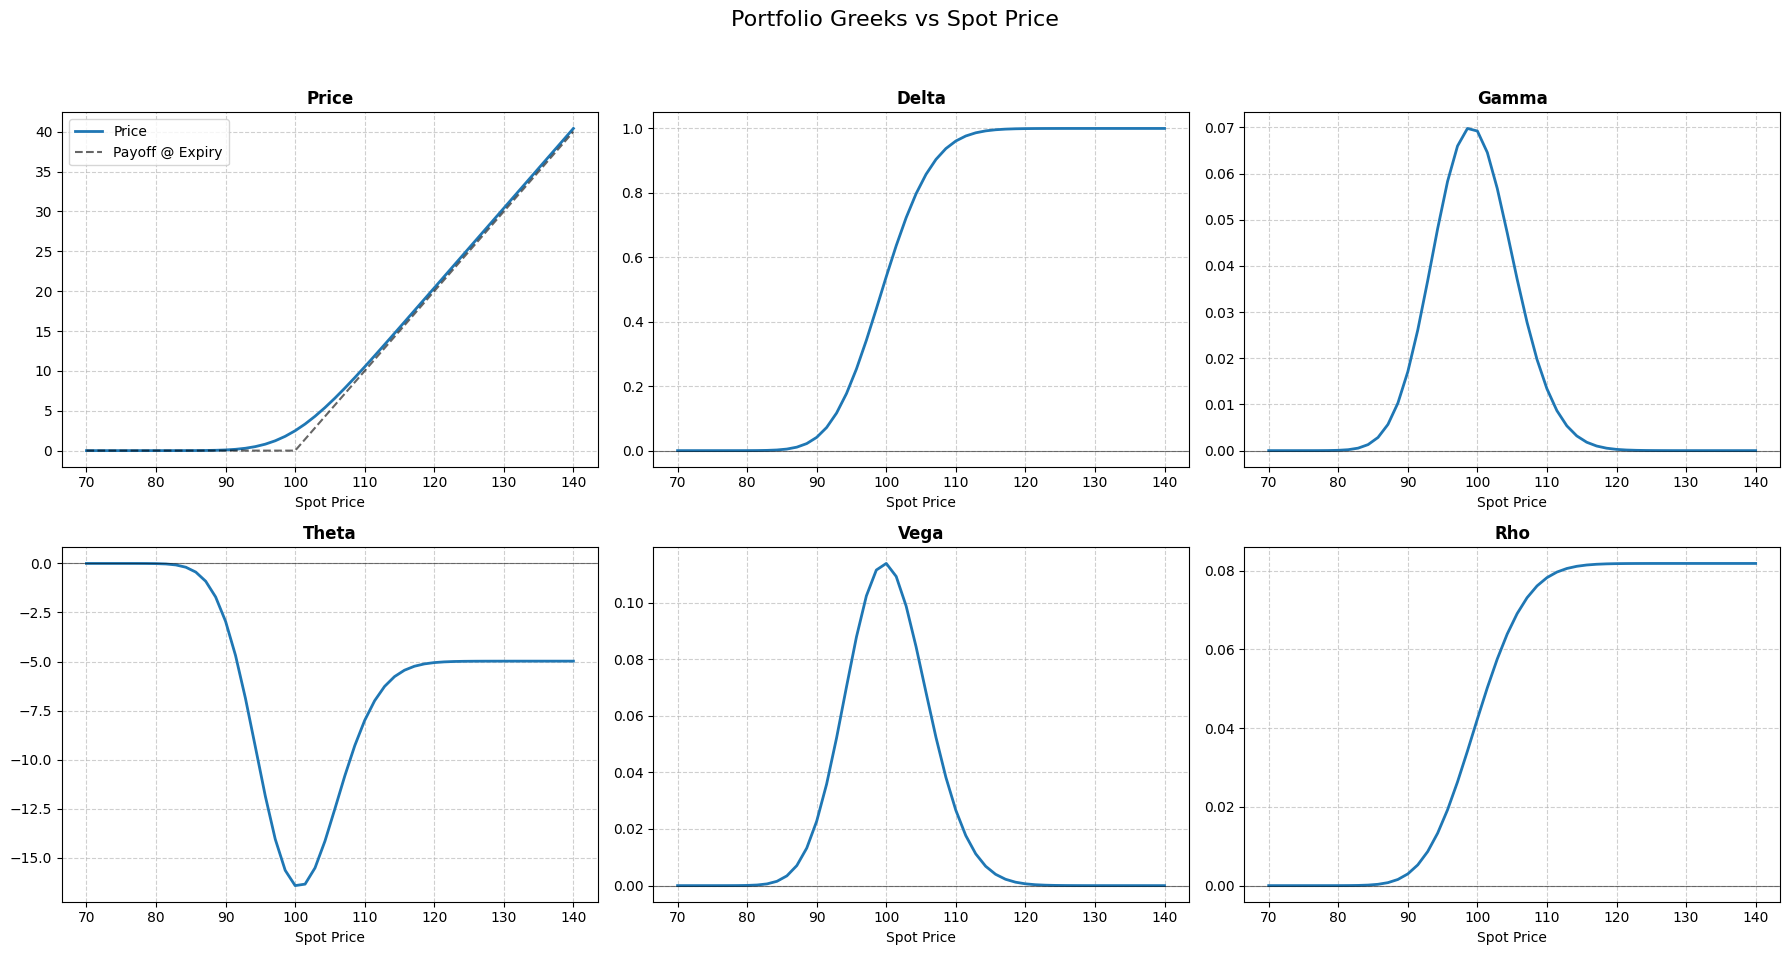

In [85]:
spots = np.linspace(70, 140, 50)
spots
portfolio = [
        {'type': 'Call', 'strike': 100, 'quantity': 1},
        # {'type': 'Put',  'strike': 100, 'quantity': 1}
    ]
results = calculate_portfolio_metrics(portfolio, spots, T=30/365, r=0.05, sigma=0.2)
plot_greeks(spots, results)

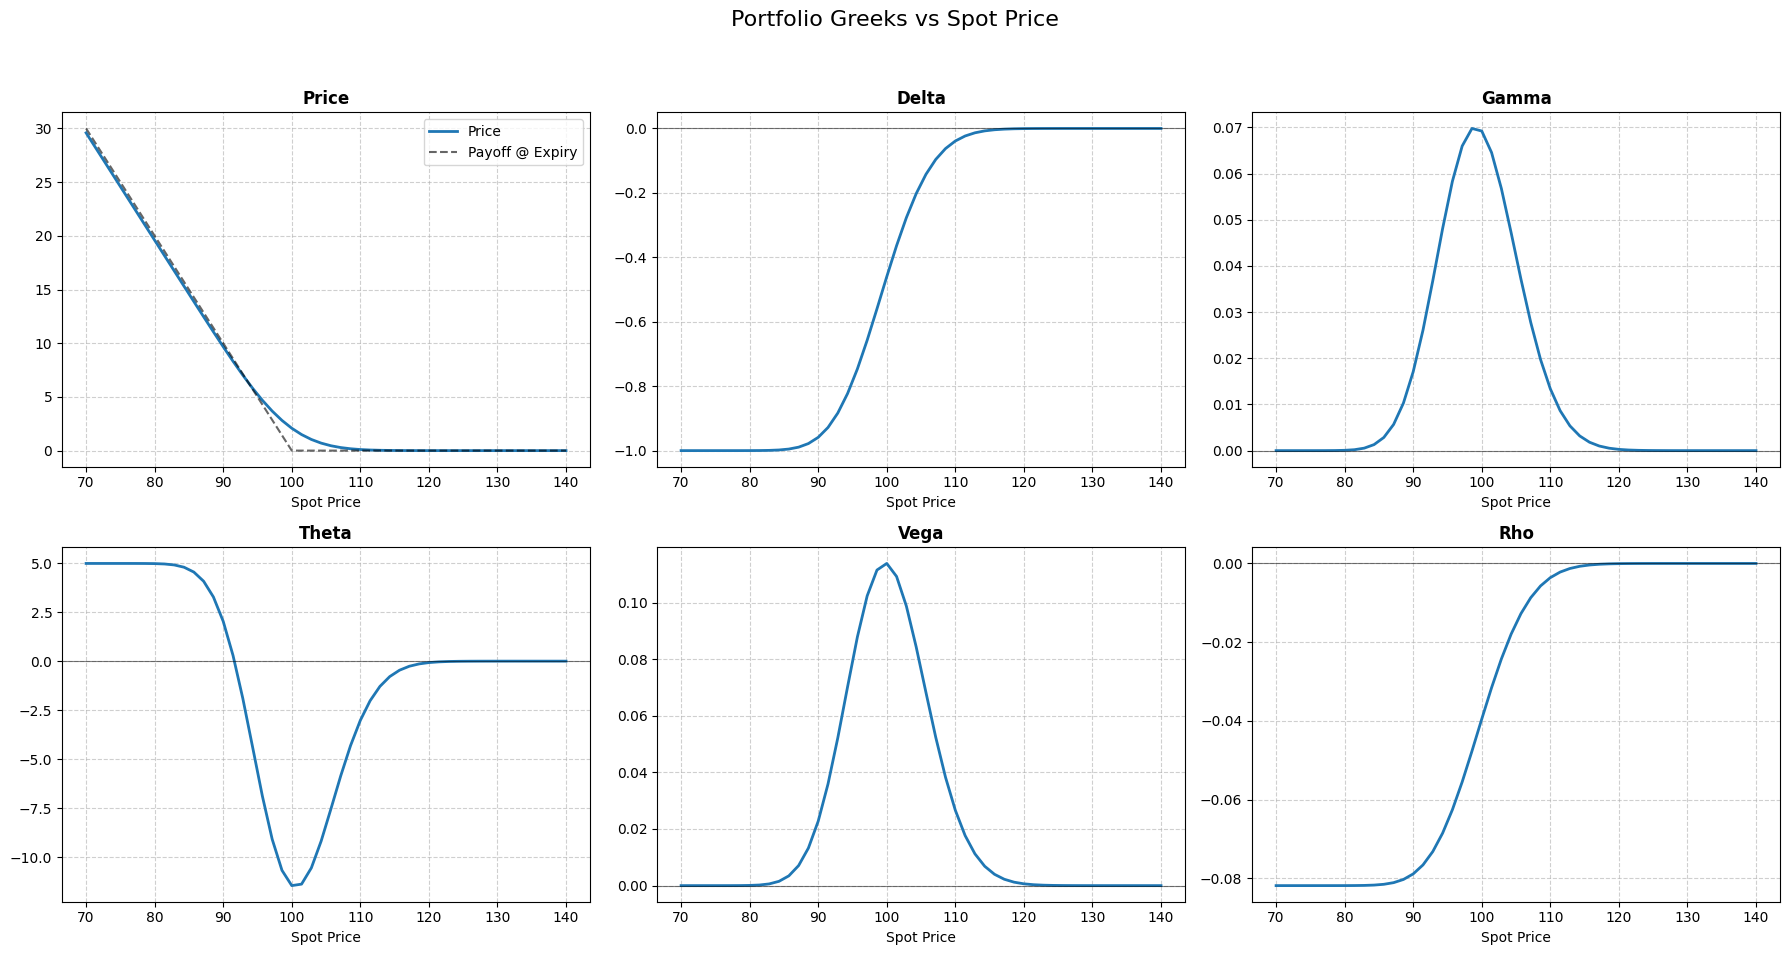

In [91]:
spots = np.linspace(70, 140, 50)
spots
portfolio = [
        {'type': 'Put', 'strike': 100, 'quantity': 1},
         # {'type': 'Put',  'strike': 90, 'quantity': -1}
    ]
results = calculate_portfolio_metrics(portfolio, spots, T=30/365, r=0.05, sigma=0.2)
plot_greeks(spots, results)

# Let's visualize more complex chains

# Straddle

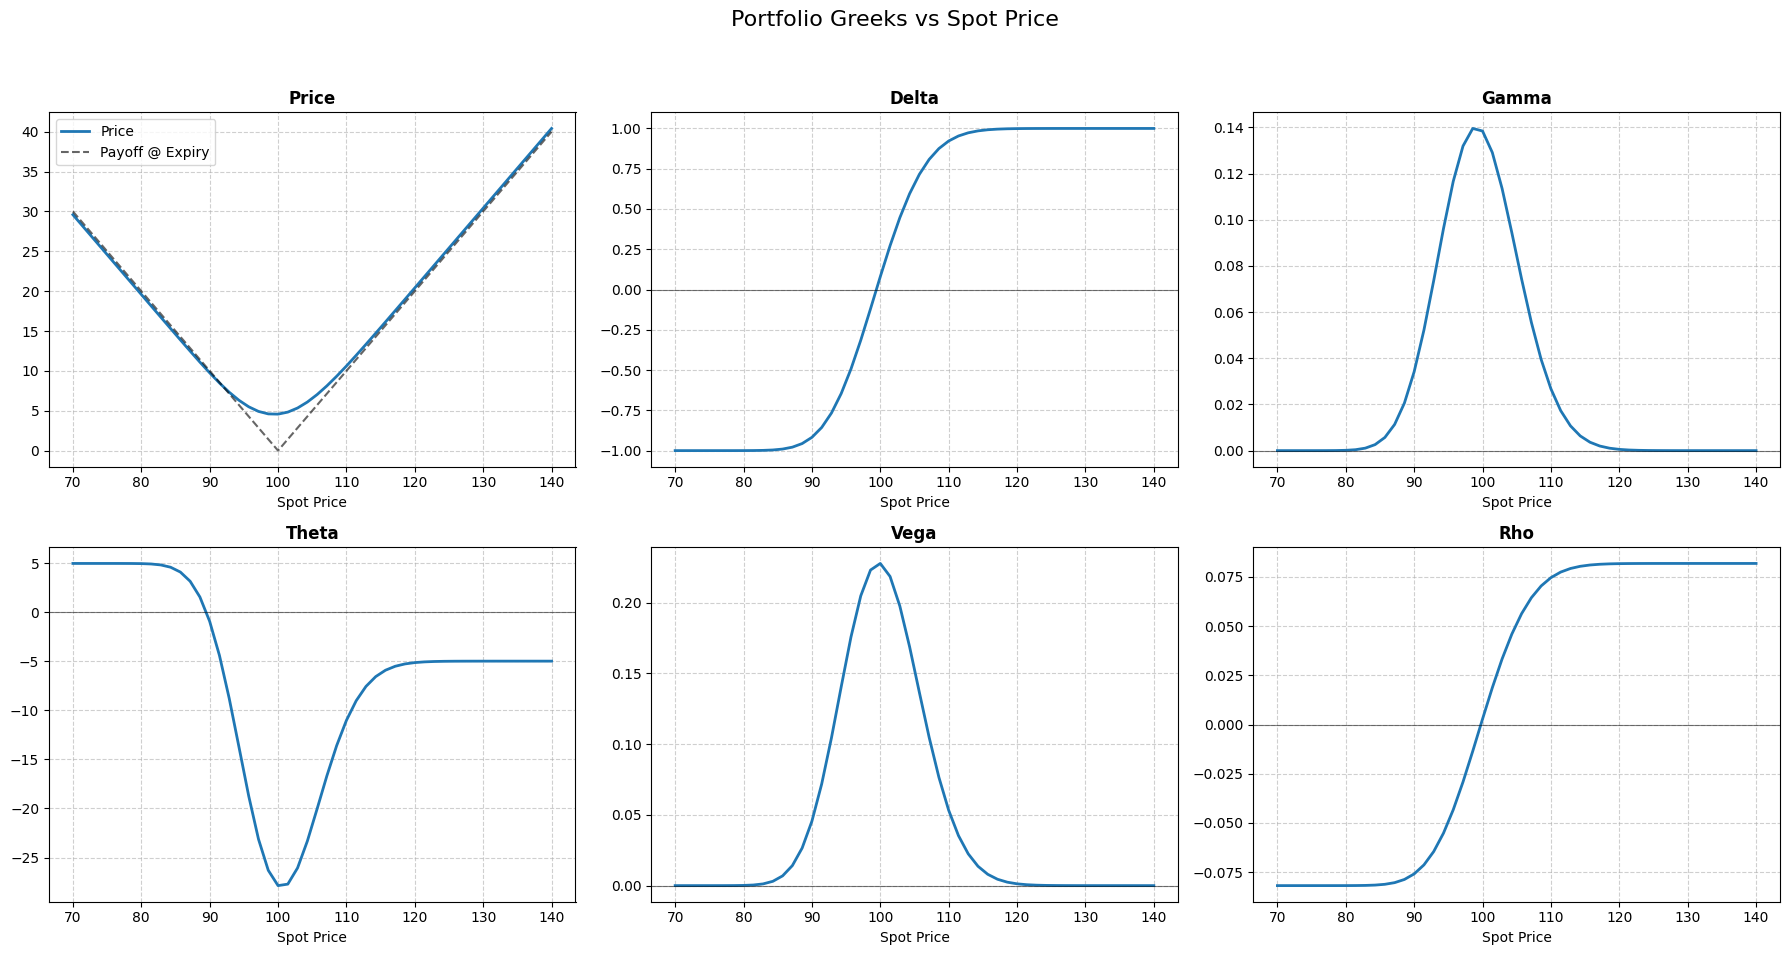

In [88]:
# Let's visualize a straddle
spots = np.linspace(70, 140, 50)
spots
portfolio = [
        {'type': 'Call', 'strike': 100, 'quantity': 1},
         {'type': 'Put',  'strike': 100, 'quantity': 1}
    ]
results = calculate_portfolio_metrics(portfolio, spots, T=30/365, r=0.05, sigma=0.2)
plot_greeks(spots, results)

# Bull Spread


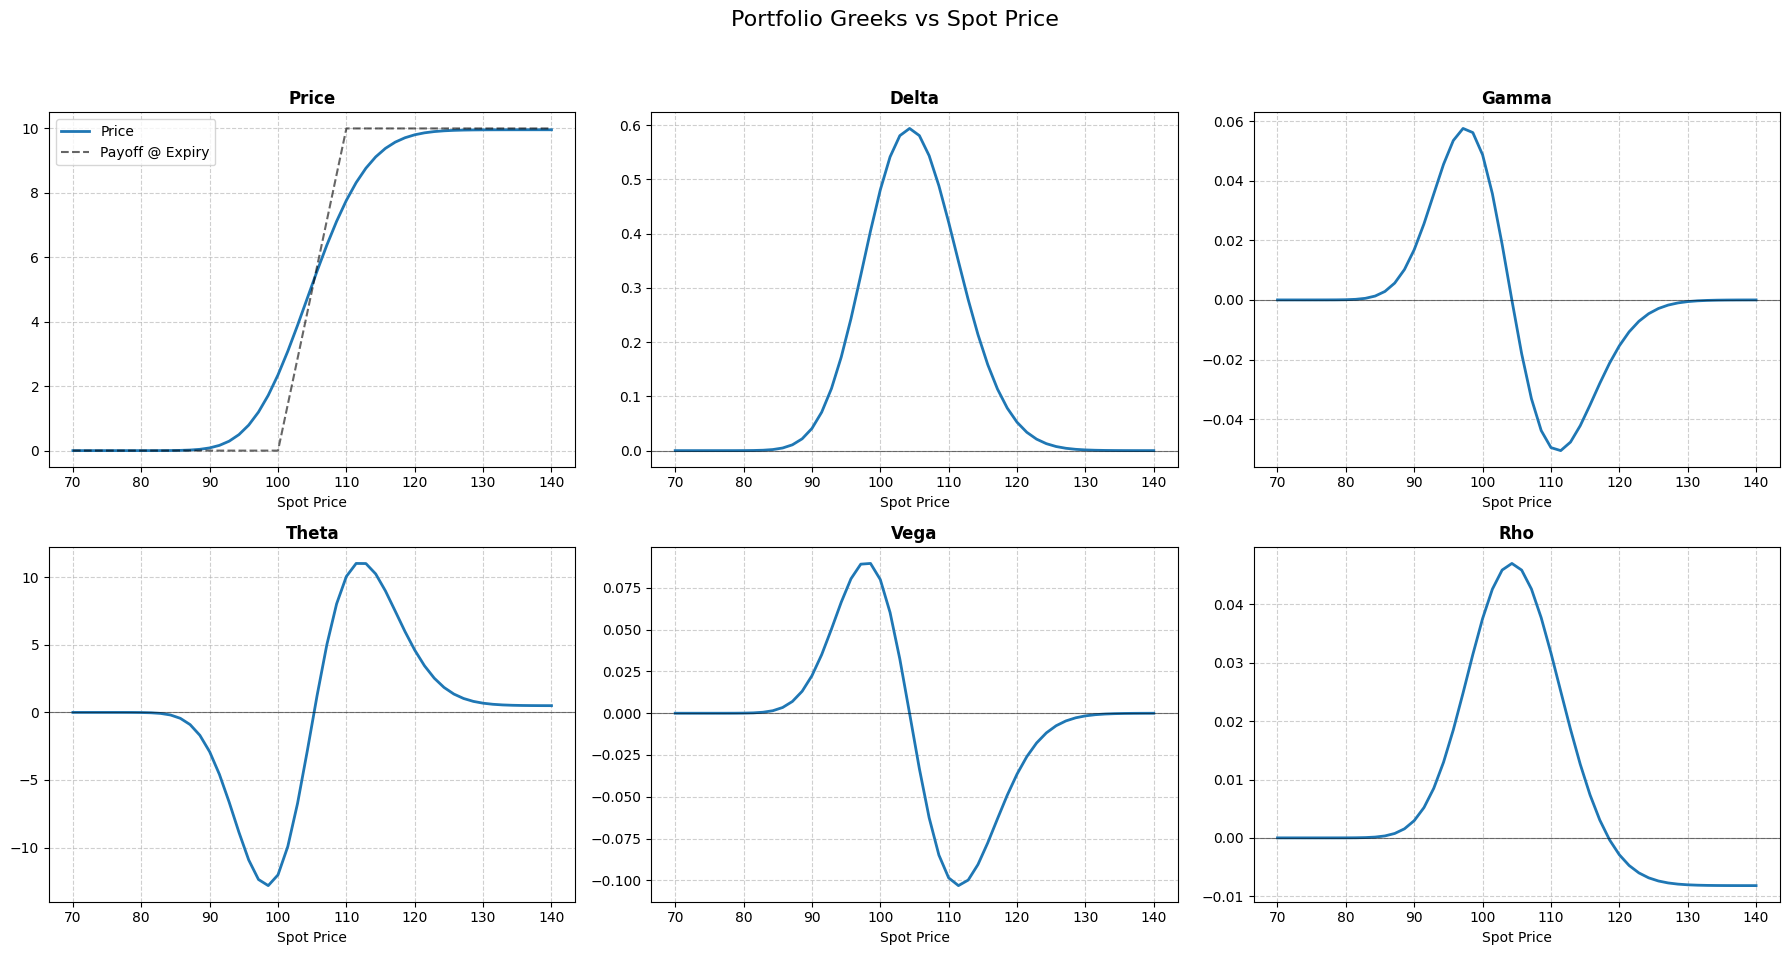

In [89]:
spots = np.linspace(70, 140, 50)
spots
portfolio = [
        {'type': 'Call', 'strike': 100, 'quantity': 1},
         {'type': 'Call',  'strike': 110, 'quantity': -1}
    ]
results = calculate_portfolio_metrics(portfolio, spots, T=30/365, r=0.05, sigma=0.2)
plot_greeks(spots, results)

# Bear spread

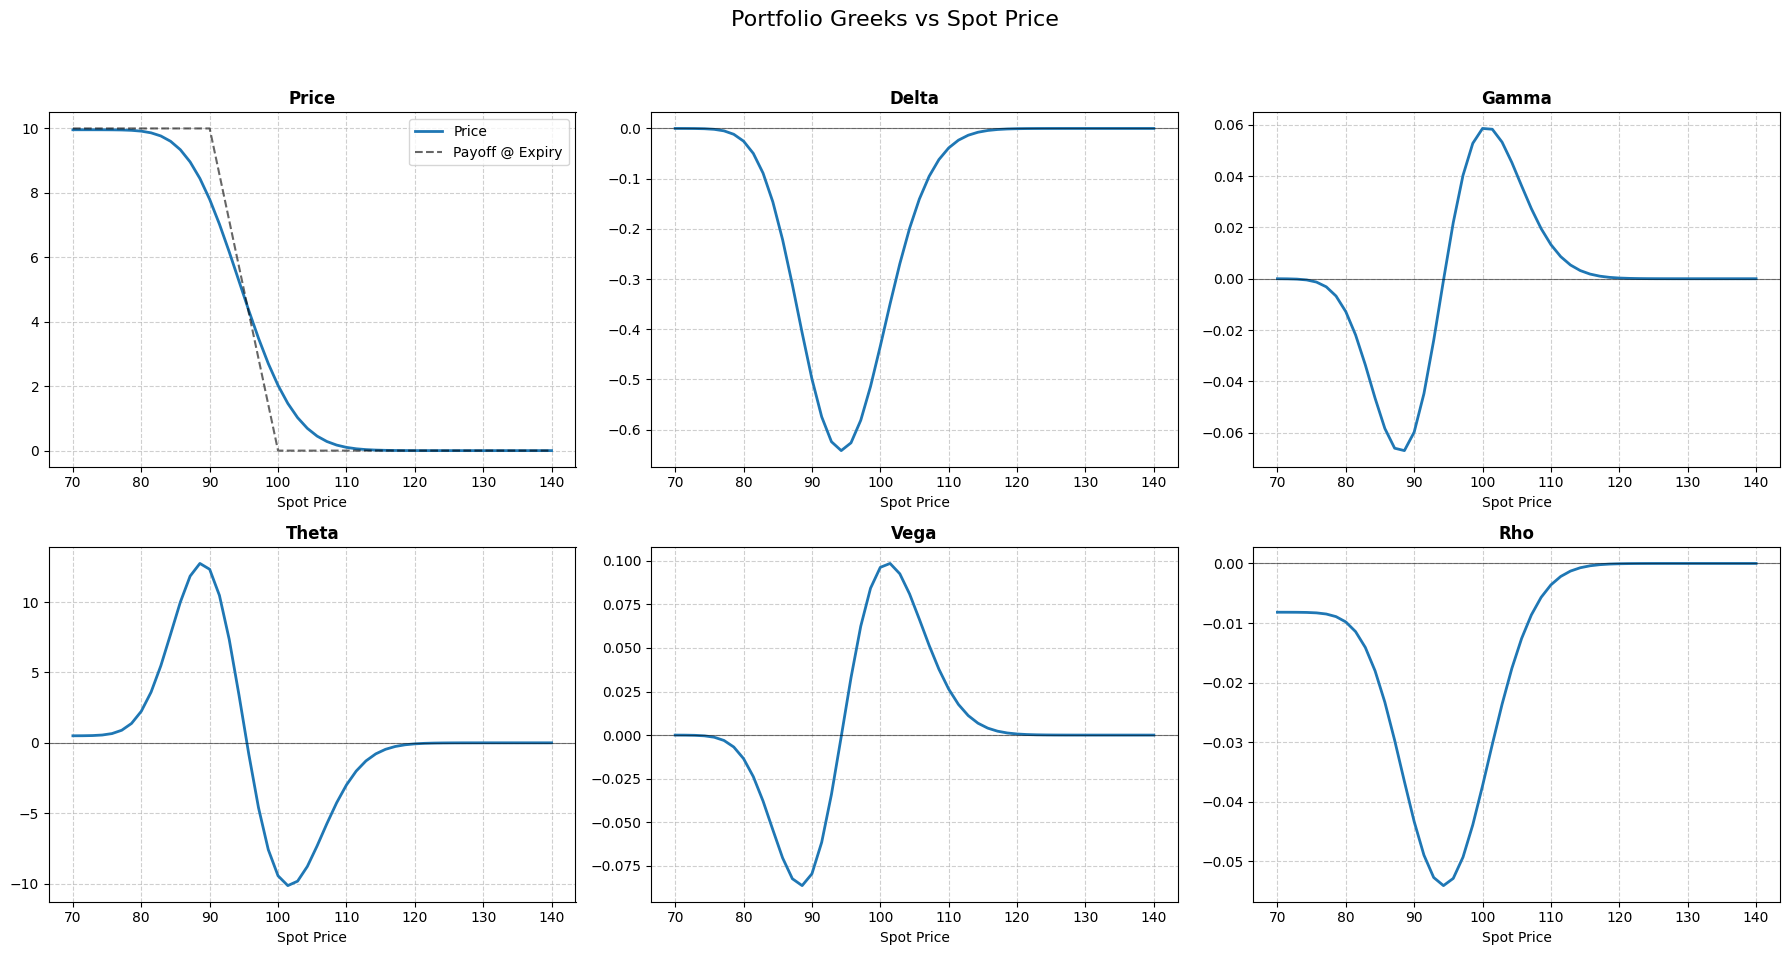

In [90]:
spots = np.linspace(70, 140, 50)
spots
portfolio = [
        {'type': 'Put', 'strike': 100, 'quantity': 1},
         {'type': 'Put',  'strike': 90, 'quantity': -1}
    ]
results = calculate_portfolio_metrics(portfolio, spots, T=30/365, r=0.05, sigma=0.2)
plot_greeks(spots, results)

# Butterfly

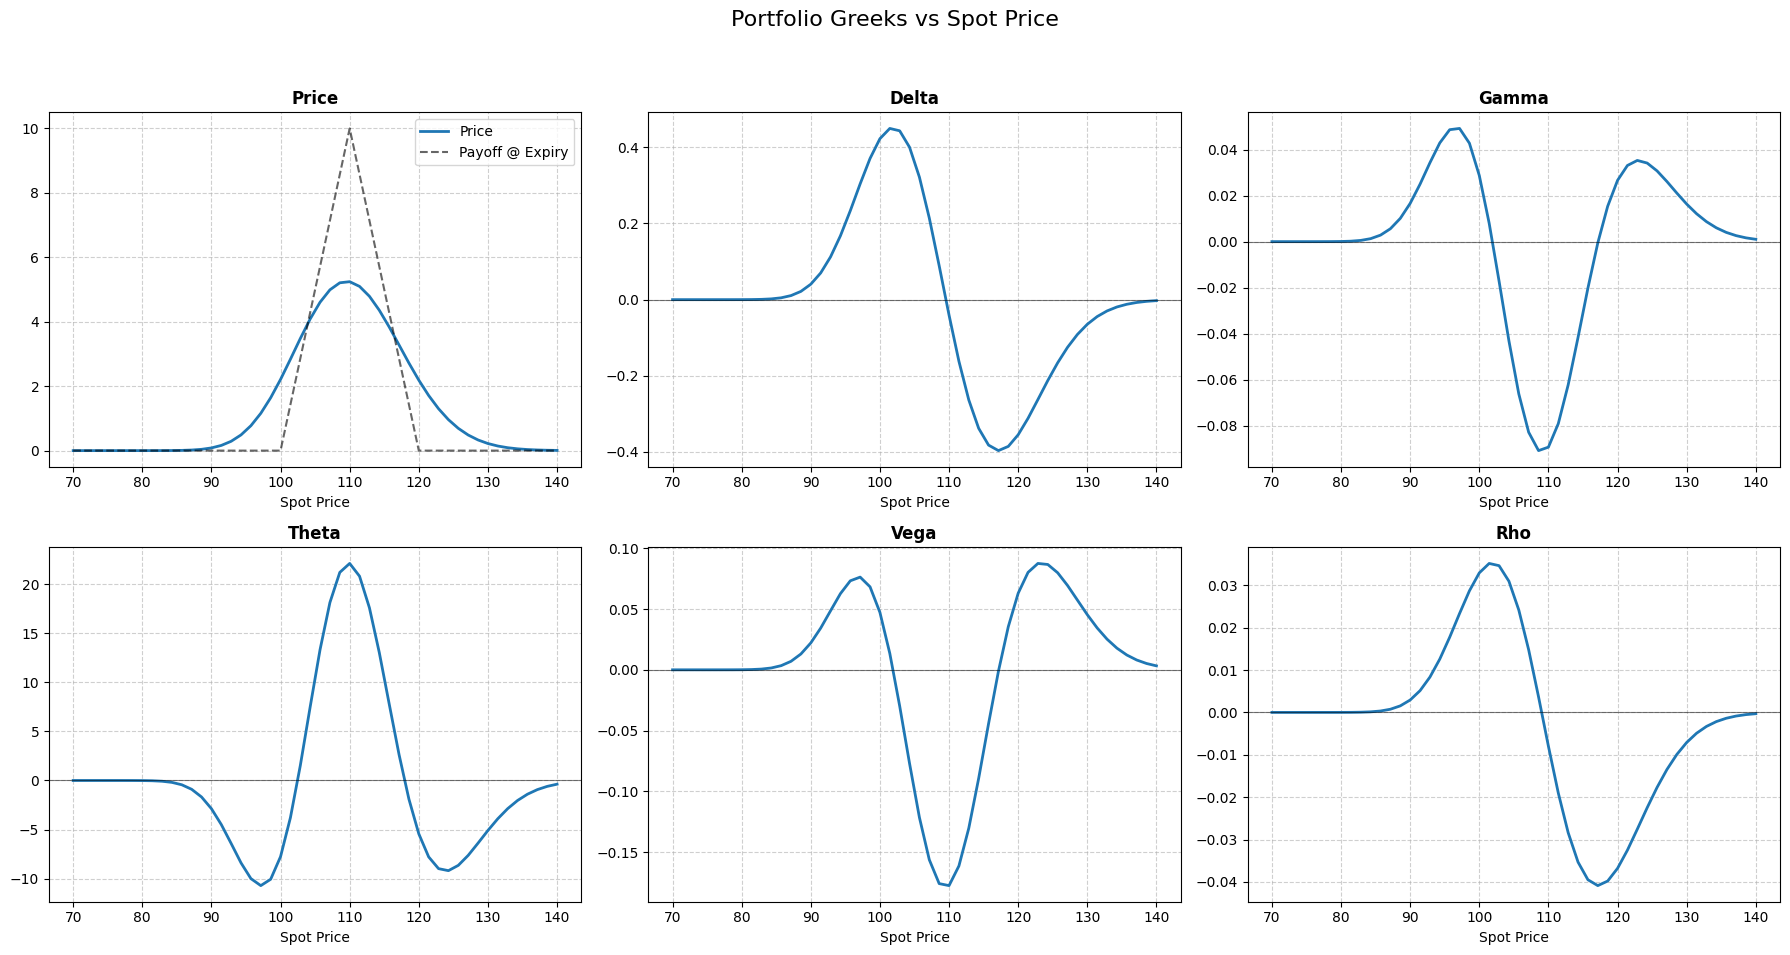

In [95]:
spots = np.linspace(70, 140, 50)
spots
portfolio = [
        {'type': 'Call', 'strike': 100, 'quantity': 1},
         {'type': 'Call',  'strike': 110, 'quantity': -2},
    {'type': 'Call',  'strike': 120, 'quantity': 1}
    ]
results = calculate_portfolio_metrics(portfolio, spots, T=30/365, r=0.05, sigma=0.2)
plot_greeks(spots, results)